In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import textwrap
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import scanpy as sc

from genes_ncbi_homo_sapiens_proteincoding import GENEID2NT as GeneID2nt_hs
from goatools.base import download_go_basic_obo
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
from goatools.base import gunzip
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from adjustText import adjust_text

In [2]:
genes_of_interest_path = (
    "/home/t.afanasyeva/MATseq/notebooks/DeSeq2/immuno_gene_symbols.txt"
)
immunoresponse_gene_df = pd.read_csv(genes_of_interest_path, sep="\t")
immunoresponse_genes = list(immunoresponse_gene_df["Approved symbol"])

In [3]:
def prepare_counts_metadata(counts, classes):
    filtered_counts = counts[counts["class"].isin(classes)]
    metadata = filtered_counts["class"]
    metadata = metadata.to_frame(name="Condition")

    filtered_counts = filtered_counts.drop("class", axis=1)
    filtered_counts = filtered_counts.T[filtered_counts.T.mean(axis=1) > 10].T

    return filtered_counts, metadata

In [4]:
def deseq(
    analysis_name,
    counts,
    metadata,
    classes_to_include,
    padj_value=0.05,
    log2foldchange_value=1,
):
    dds = DeseqDataSet(counts=counts, metadata=metadata, design_factors="Condition")
    dds.deseq2()

    sns.set_theme(context="notebook", style="white")
    sc.tl.pca(dds)
    sc.pl.pca(dds, color="Condition", size=200, save=f"_{analysis_name}.png")

    stat_res = DeseqStats(dds, contrast=("Condition", *classes_to_include))
    stat_res.summary()
    res = stat_res.results_df
    res = res[res.baseMean >= 10]
    sigs = res[
        (res.padj < padj_value) & (abs(res.log2FoldChange) > log2foldchange_value)
    ]

    return (dds, res, sigs)

In [5]:
def make_historgram_for_sign_genes(dds, sigs, num_top_sign):
    if num_top_sign != "all":
        sigs = sigs.sort_values("padj")[:num_top_sign]

    dds_sigs = dds[:, sigs.index]
    dds_sigs.layers["log1p"] = np.log1p(dds_sigs.layers["normed_counts"])

    grapher = pd.DataFrame(
        dds_sigs.layers["log1p"].T, index=dds_sigs.var_names, columns=dds_sigs.obs_names
    )

    plt.figure(figsize=(12, 12))
    sns.set_theme(
        context="notebook",
        style="darkgrid",
        palette="deep",
        font="sans-serif",
        font_scale=0.7,
        color_codes=True,
        rc=None,
    )

    sns.clustermap(grapher, z_score=0, cmap="RdYlBu_r")

    plt.savefig(
        f"{results_directory}/{analysis_name}_histo_sign.png",
        dpi=300,
        bbox_inches="tight",
        facecolor="white",
    )

In [6]:
def initialise_go():
    # obo_fname = download_go_basic_obo() # Already downloaded the go-basic.obo
    # fin_gene2go = gunzip("gene2go.gz") # Already unzipped the file

    fin_gene2go = "gene2go"
    obodag = GODag("go-basic.obo")

    mapper = {}
    for key in GeneID2nt_hs:
        mapper[GeneID2nt_hs[key].Symbol] = GeneID2nt_hs[key].GeneID

    objanno = Gene2GoReader(fin_gene2go, taxids=[9606])

    """
    Get namespace2association where:
       namespace is:
           BP: biological_process
           MF: molecular_function
           CC: cellular_component
       assocation is a dict:
           key: NCBI GeneID
           value: A set of GO IDs associated with that gene
    """
    ns2assoc = objanno.get_ns2assc()

    goeaobj = GOEnrichmentStudyNS(
        GeneID2nt_hs.keys(),  # List of human protein-coding genes
        ns2assoc,  # Geneid/GO associations
        obodag,  # Ontologies
        propagate_counts=False,
        alpha=0.05,  # Default significance cut-off
        methods=["fdr_bh"],  # Default multipletest correction method
    )

    go_items = []

    temp = goeaobj.ns2objgoea["BP"].assoc
    for item in temp:
        go_items += temp[item]

    temp = goeaobj.ns2objgoea["CC"].assoc
    for item in temp:
        go_items += temp[item]

    temp = goeaobj.ns2objgoea["MF"].assoc
    for item in temp:
        go_items += temp[item]

    return mapper, goeaobj, go_items


def go_it(test_genes, mapper, goeaobj, go_items):
    print(f"input genes: {len(test_genes)}")

    inv_map = {v: k for k, v in mapper.items()}

    mapped_genes = []
    for gene in test_genes:
        try:
            mapped_genes.append(mapper[gene])
        except:
            pass
    print(f"mapped genes: {len(mapped_genes)}")

    goea_results_all = goeaobj.run_study(mapped_genes)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]

    GO = pd.DataFrame(
        list(
            map(
                lambda x: [
                    x.GO,
                    x.goterm.name,
                    x.goterm.namespace,
                    x.p_uncorrected,
                    x.p_fdr_bh,
                    x.ratio_in_study[0],
                    x.ratio_in_study[1],
                    go_items.count(x.GO),
                    list(map(lambda y: inv_map[y], x.study_items)),
                    x.ratio_in_study[0] / go_items.count(x.GO),
                ],
                goea_results_sig,
            )
        ),
        columns=[
            "GO",
            "term",
            "class",
            "p",
            "p_corr",
            "n_genes",
            "n_study",
            "n_go",
            "study_genes",
            "per",
        ],
    )

    GO = GO[GO.n_genes > 1]
    return GO


def make_go_plot(df, results_directory, analysis_name):
    fig, ax = plt.subplots(figsize=(10, 6))
    cmap = mpl.cm.bwr_r
    norm = mpl.colors.Normalize(vmin=df.p_corr.min(), vmax=df.p_corr.max())
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    sns.barplot(
        data=df,
        x="per",
        y="term",
        palette=list(mapper.to_rgba(df.p_corr.values)),
        ax=ax,
    )
    ax.set_yticklabels([textwrap.fill(e, 30) for e in df["term"]])

    cbar = fig.colorbar(mapper, ax=ax, orientation="vertical", pad=0.01)
    cbar.ax.set_position([0.8, 0.5, 0.2, 0.3])

    plt.savefig(
        f"{results_directory}/{analysis_name}_go.png",
        dpi=300,
        bbox_inches="tight",
        facecolor="white",
    )


mapper, goeaobj, go_items = initialise_go()

go-basic.obo: fmt(1.2) rel(2023-11-15) 46,228 Terms
HMS:0:00:48.548160 345,172 annotations, 20,754 genes, 18,774 GOs, 1 taxids READ: gene2go 

Load BP Ontology Enrichment Analysis ...
 82% 17,005 of 20,615 population items found in association

Load CC Ontology Enrichment Analysis ...
 88% 18,132 of 20,615 population items found in association

Load MF Ontology Enrichment Analysis ...
 85% 17,589 of 20,615 population items found in association


In [7]:
def map_color(gene, overexpressed, underexpressed):
    if gene in overexpressed:
        return "overexpressed"
    elif gene in underexpressed:
        return "underexpressed"
    else:
        return "no_expression_change"


def map_shape(gene, immunoresponse_genes):
    if gene in immunoresponse_genes:
        return "immunoresponse"
    else:
        return "no_immunoresponse"


def make_volcano_plot(
    res,
    genes_of_interest,
    results_directory,
    analysis_name,
    sign_log2FoldChange=2,
    sign_padj=0.05,
):
    sign_genes = res[(res["padj"] < sign_padj)]
    overexpressed = list(
        sign_genes[(sign_genes["log2FoldChange"] > sign_log2FoldChange)].index
    )
    underexpressed = list(
        sign_genes[(sign_genes["log2FoldChange"] < -sign_log2FoldChange)].index
    )

    df = res.reset_index(names="gene")
    df["padj_log"] = -np.log10(df["padj"])

    df["color"] = df.apply(
        lambda row: map_color(row["gene"], overexpressed, underexpressed),
        axis=1,
    )

    df["shape"] = df.apply(
        lambda row: map_shape(row["gene"], genes_of_interest),
        axis=1,
    )

    plt.figure(figsize=(10, 12))
    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(context="notebook", style="white", rc=custom_params)

    ax = sns.scatterplot(
        data=df,
        x="log2FoldChange",
        y="padj_log",
        hue="color",
        hue_order=["no_expression_change", "overexpressed", "underexpressed"],
        palette=["grey", "orange", "purple"],
        style="shape",
        style_order=["immunoresponse", "no_immunoresponse"],
        markers=["s", "o"],
        size="baseMean",
        sizes=(20, 200),
    )

    ax.axhline(1.3, zorder=1, c="k", lw=1, ls="--")
    ax.axvline(2, zorder=1, c="k", lw=1, ls="--")
    ax.axvline(-2, zorder=1, c="k", lw=1, ls="--")

    ax.tick_params(width=2)

    texts = []
    for i in range(len(df)):
        if (
            df.iloc[i].padj < sign_padj
            and abs(df.iloc[i].log2FoldChange) > sign_log2FoldChange
        ):
            texts.append(
                plt.text(
                    x=df.iloc[i].log2FoldChange,
                    y=df.iloc[i].padj_log,
                    s=df.iloc[i].gene,
                    fontsize=10,
                    weight="bold",
                )
            )

    adjust_text(texts, arrowprops=dict(arrowstyle="-", color="k"))
    plt.legend(loc=1, bbox_to_anchor=(1.3, 1), frameon=False, prop={"weight": "bold"})

    plt.xticks(size=10, weight="bold")
    plt.yticks(size=10, weight="bold")

    plt.xlabel("$log_{2}$ fold change")
    plt.ylabel("-$log_{10}$ FDR")

    plt.savefig(
        f"{results_directory}/{analysis_name}_volcano.png",
        dpi=300,
        bbox_inches="tight",
        facecolor="white",
    )

In [8]:
file_path = "/home/t.afanasyeva/MATseq/notebooks/gene_counts_7128_61_training.csv"
raw_counts = pd.read_csv(file_path, index_col="sample")

In [9]:
list_of_classes_to_include = []
for my_class in raw_counts["class"].unique():
    if my_class != "IMDM":
        list_of_classes_to_include.append([my_class, "IMDM"])

In [10]:
list_of_classes_to_include

[['Fla-St', 'IMDM'],
 ['LPS', 'IMDM'],
 ['Pam3', 'IMDM'],
 ['R848', 'IMDM'],
 ['CL-307', 'IMDM'],
 ['CRX-527', 'IMDM'],
 ['Fla-PA', 'IMDM']]

In [11]:
current_directory = os.getcwd()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.15 seconds.

Fitting dispersion trend curve...
... done in 0.58 seconds.

Fitting MAP dispersions...
... done in 1.15 seconds.

Fitting LFCs...
... done in 1.14 seconds.

Refitting 1 outliers.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



/home/t.afanasyeva/mambaforge/envs/pydeseq2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


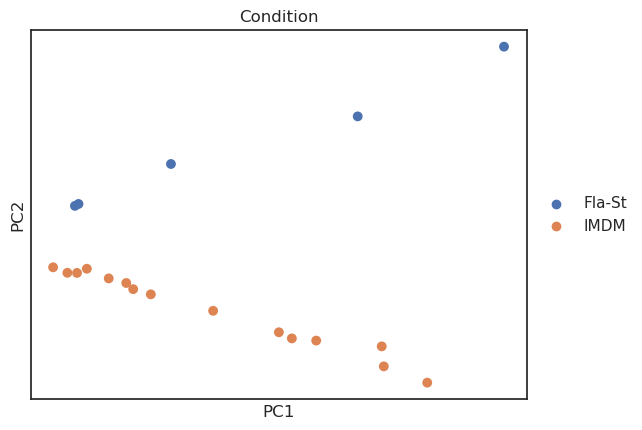

Running Wald tests...
... done in 1.13 seconds.

/tmp/ipykernel_3556066/1625812066.py:6: ImplicitModificationWarning: Setting element `.layers['log1p']` of view, initializing view as actual.
  dds_sigs.layers["log1p"] = np.log1p(dds_sigs.layers["normed_counts"])


Log2 fold change & Wald test p-value: Condition Fla-St vs IMDM
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
KLHL8    120.333738        0.316378  0.108293  2.921511  0.003483  0.015022
ZNF576    56.673512        0.029968  0.136566  0.219442  0.826306  0.905178
FCF1     300.196411        0.200119  0.111840  1.789329  0.073562  0.176052
TAF12    100.435973        0.156877  0.145231  1.080189  0.280058  0.457967
GLRX      86.912713        0.373890  0.162447  2.301616  0.021357  0.066666
...             ...             ...       ...       ...       ...       ...
TSN      425.708770       -0.013018  0.076159 -0.170935  0.864275  0.925818
NFATC1   475.643137       -0.130851  0.071741 -1.823952  0.068159  0.166247
PORCN     35.705585        0.090570  0.187163  0.483908  0.628451  0.768524
REL     2857.053242        0.231068  0.084701  2.728029  0.006371  0.024931
RPL23   3664.683706        0.194153  0.138181  1.405057  0.160004  0.309406

[11993 rows x 6 columns]

/tmp/ipykernel_3556066/202939109.py:116: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([textwrap.fill(e, 30) for e in df["term"]])
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.19 seconds.

Fitting dispersion trend curve...
... done in 0.31 seconds.

Fitting MAP dispersions...
... done in 1.26 seconds.

Fitting LFCs...


... done in 1.51 seconds.

Refitting 0 outliers.

/home/t.afanasyeva/mambaforge/envs/pydeseq2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 1200x1200 with 0 Axes>

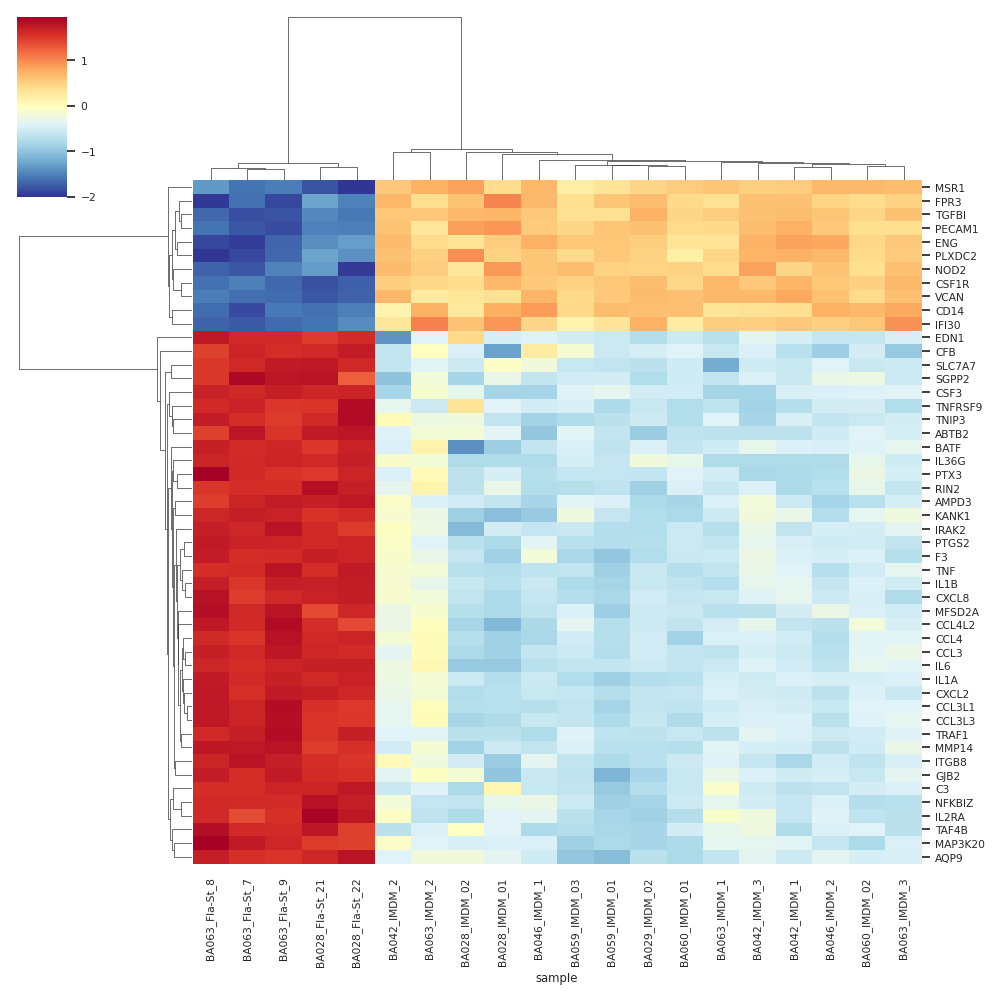

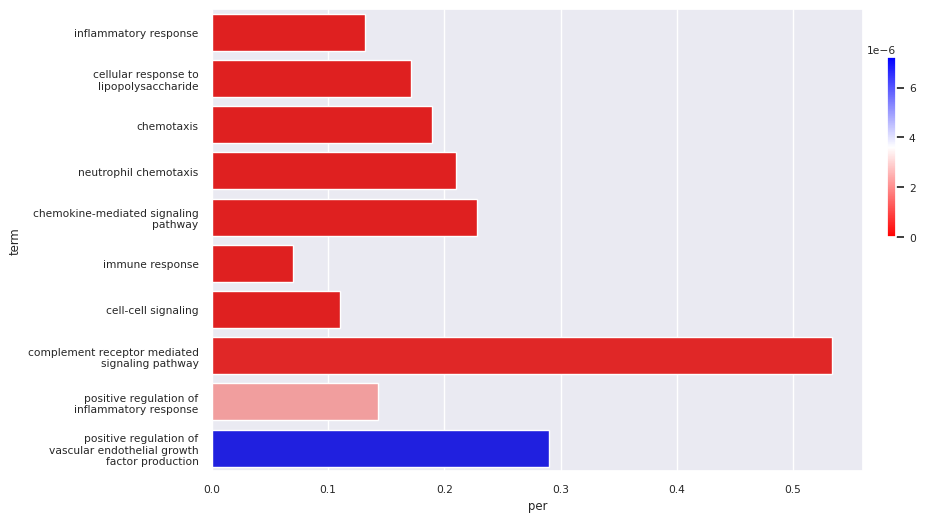

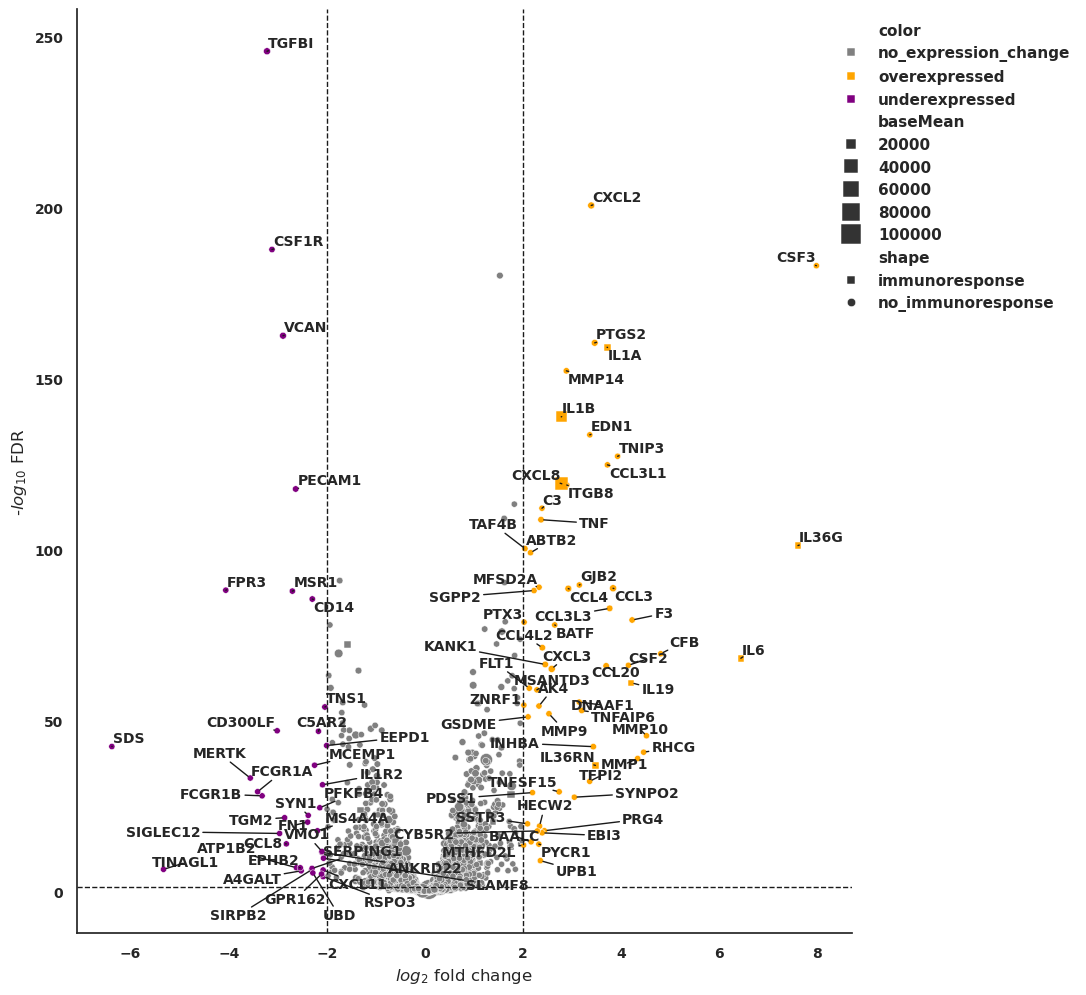

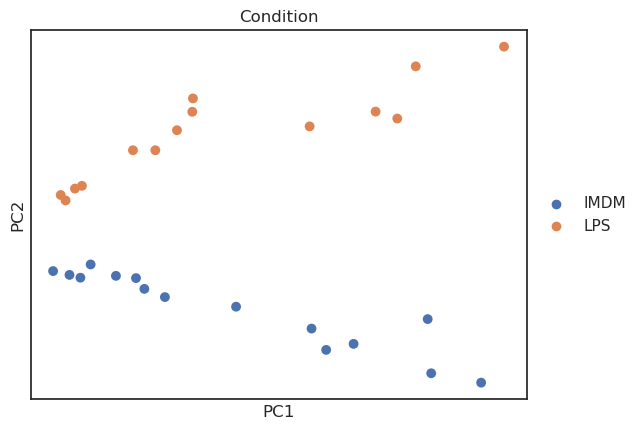

Running Wald tests...
... done in 1.12 seconds.

/tmp/ipykernel_3556066/1625812066.py:6: ImplicitModificationWarning: Setting element `.layers['log1p']` of view, initializing view as actual.
  dds_sigs.layers["log1p"] = np.log1p(dds_sigs.layers["normed_counts"])


Log2 fold change & Wald test p-value: Condition LPS vs IMDM
           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
KLHL8    124.022463        0.254957  0.069677  3.659139  2.530636e-04   
ZNF576    53.753344       -0.108473  0.093842 -1.155904  2.477202e-01   
FCF1     290.855180        0.036746  0.070922  0.518122  6.043732e-01   
TAF12     95.446778       -0.017782  0.083682 -0.212500  8.317167e-01   
GLRX      97.983598        0.537916  0.086070  6.249718  4.111932e-10   
...             ...             ...       ...       ...           ...   
TSN      416.993014       -0.048910  0.054974 -0.889686  3.736345e-01   
NFATC1   487.655820        0.021098  0.048673  0.433478  6.646677e-01   
PORCN     34.413423        0.035432  0.110874  0.319571  7.492939e-01   
REL     2889.474458        0.169719  0.066169  2.564917  1.032004e-02   
RPL23   3564.885798        0.038061  0.094467  0.402905  6.870178e-01   

                padj  
KLHL8   2.191142e-03  
ZNF576  5.046340e

/tmp/ipykernel_3556066/202939109.py:116: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([textwrap.fill(e, 30) for e in df["term"]])
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.46 seconds.

Fitting dispersion trend curve...
... done in 0.39 seconds.

Fitting MAP dispersions...
... done in 1.23 seconds.

Fitting LFCs...


... done in 1.15 seconds.

Refitting 1 outliers.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

/home/t.afanasyeva/mambaforge/envs/pydeseq2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 1200x1200 with 0 Axes>

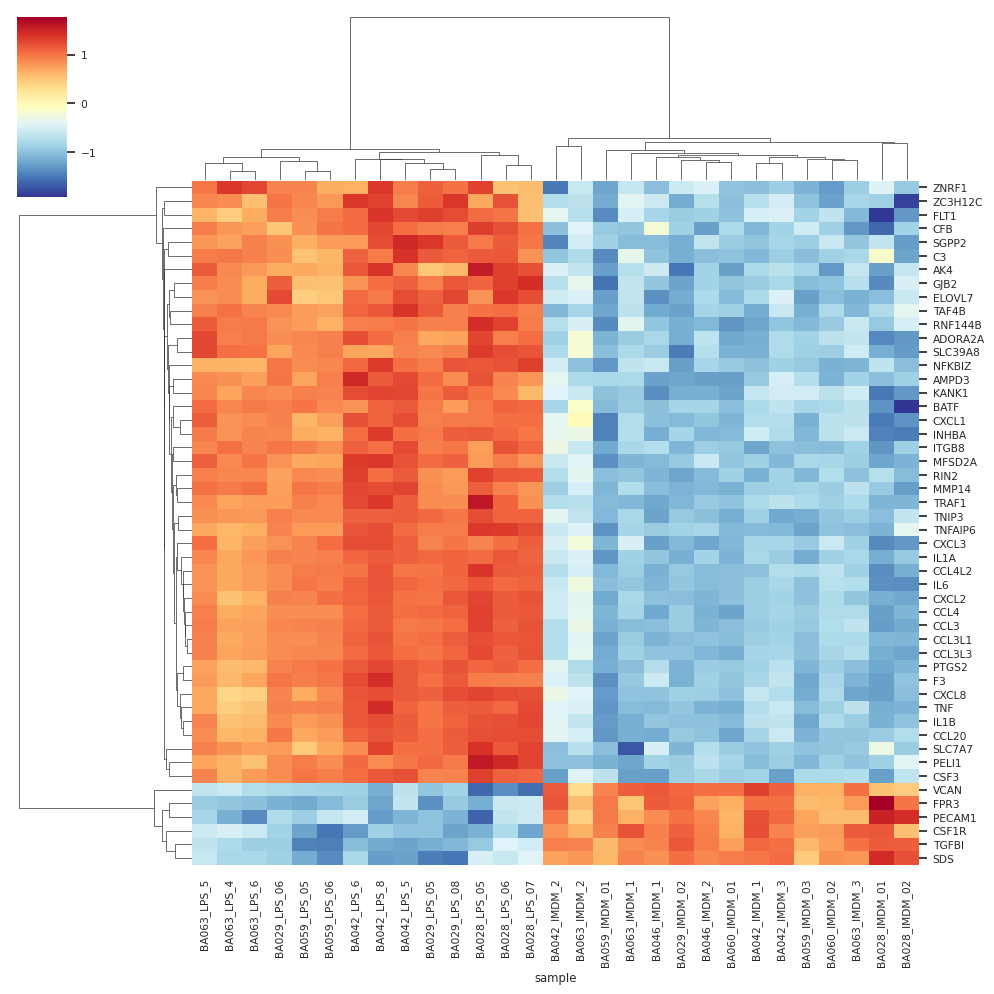

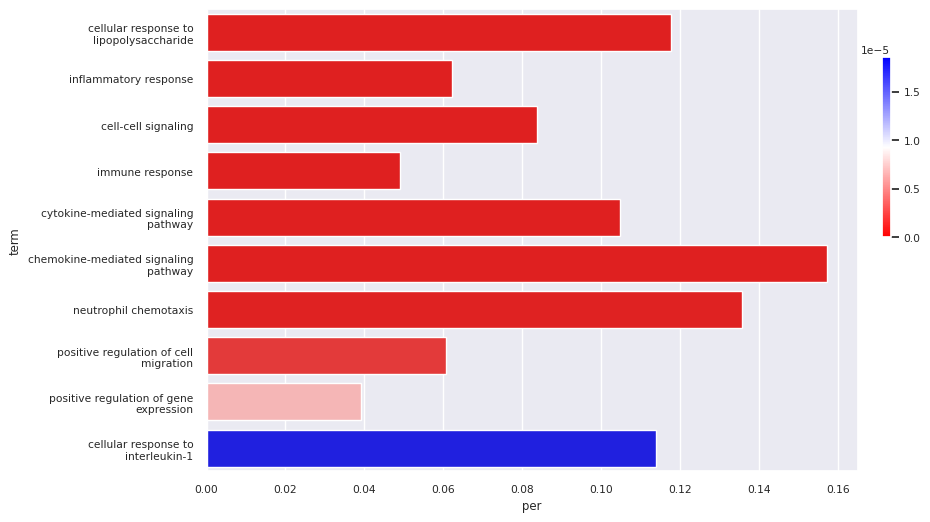

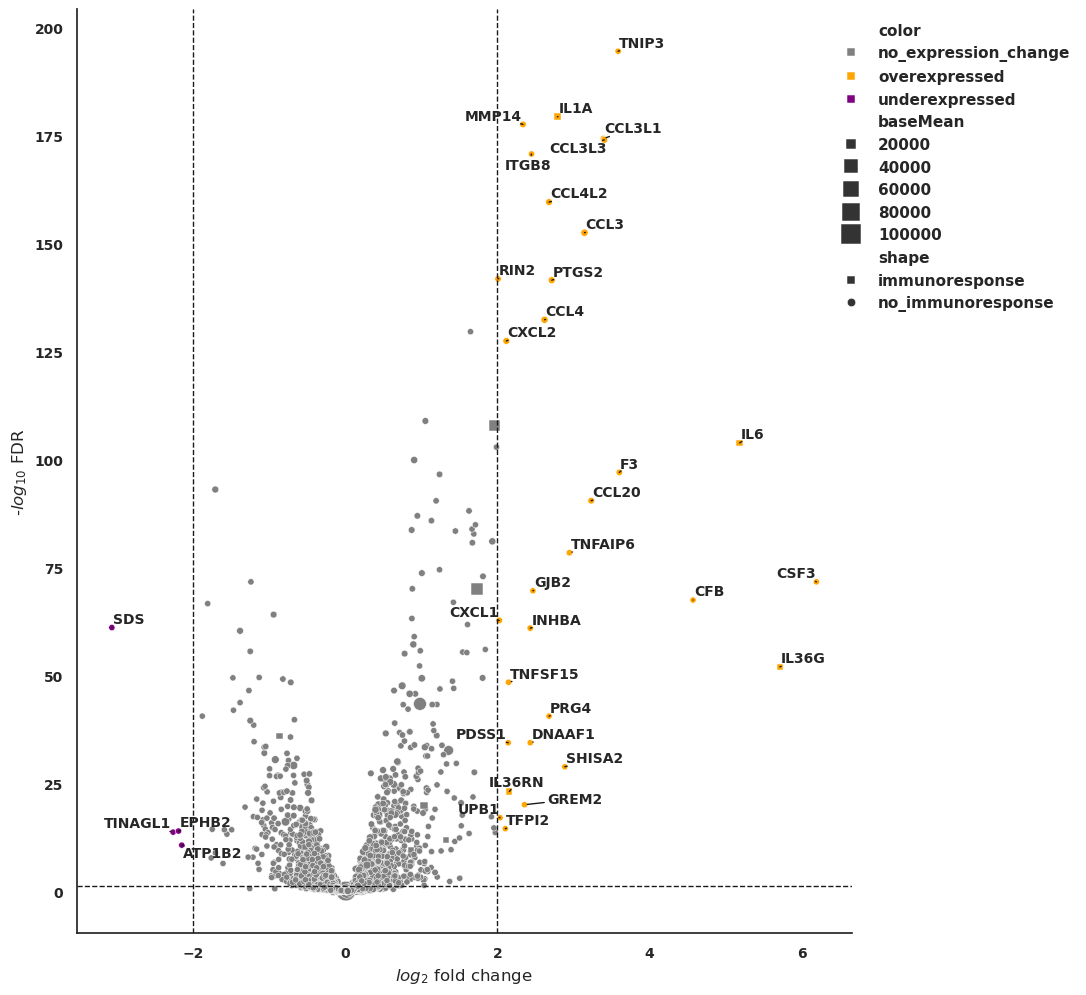

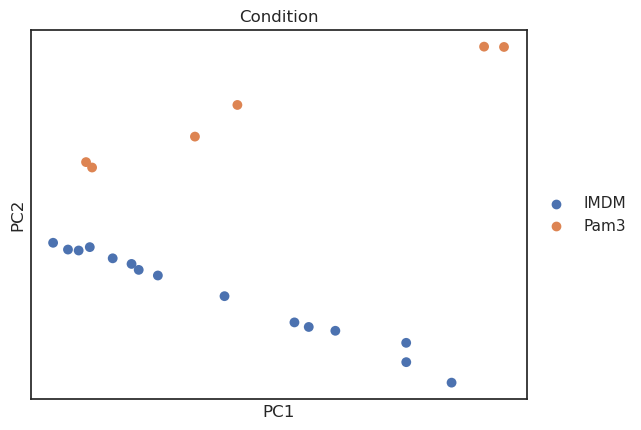

Running Wald tests...
... done in 1.11 seconds.

/tmp/ipykernel_3556066/1625812066.py:6: ImplicitModificationWarning: Setting element `.layers['log1p']` of view, initializing view as actual.
  dds_sigs.layers["log1p"] = np.log1p(dds_sigs.layers["normed_counts"])


Log2 fold change & Wald test p-value: Condition Pam3 vs IMDM
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
KLHL8    120.352006        0.312219  0.086155  3.623902  0.000290  0.001602
ZNF576    53.964811       -0.217547  0.136936 -1.588679  0.112133  0.234857
FCF1     290.025607        0.080396  0.099192  0.810508  0.417648  0.586549
TAF12     93.872799       -0.090391  0.116810 -0.773827  0.439033  0.606342
GLRX      84.786920        0.324348  0.150135  2.160378  0.030743  0.086965
...             ...             ...       ...       ...       ...       ...
TSN      431.068576        0.092852  0.068277  1.359930  0.173852  0.322245
NFATC1   490.696991        0.100859  0.064317  1.568149  0.116846  0.241559
PORCN     31.522582       -0.374335  0.166798 -2.244243  0.024817  0.073281
REL     2871.533993        0.277948  0.084031  3.307665  0.000941  0.004585
RPL23   3675.634604        0.237520  0.131600  1.804872  0.071095  0.167301

[11974 rows x 6 columns]
i

/tmp/ipykernel_3556066/202939109.py:116: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([textwrap.fill(e, 30) for e in df["term"]])
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.08 seconds.

Fitting dispersion trend curve...
... done in 0.43 seconds.

Fitting MAP dispersions...
... done in 1.54 seconds.

Fitting LFCs...


... done in 1.14 seconds.

Refitting 3 outliers.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

/home/t.afanasyeva/mambaforge/envs/pydeseq2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 1200x1200 with 0 Axes>

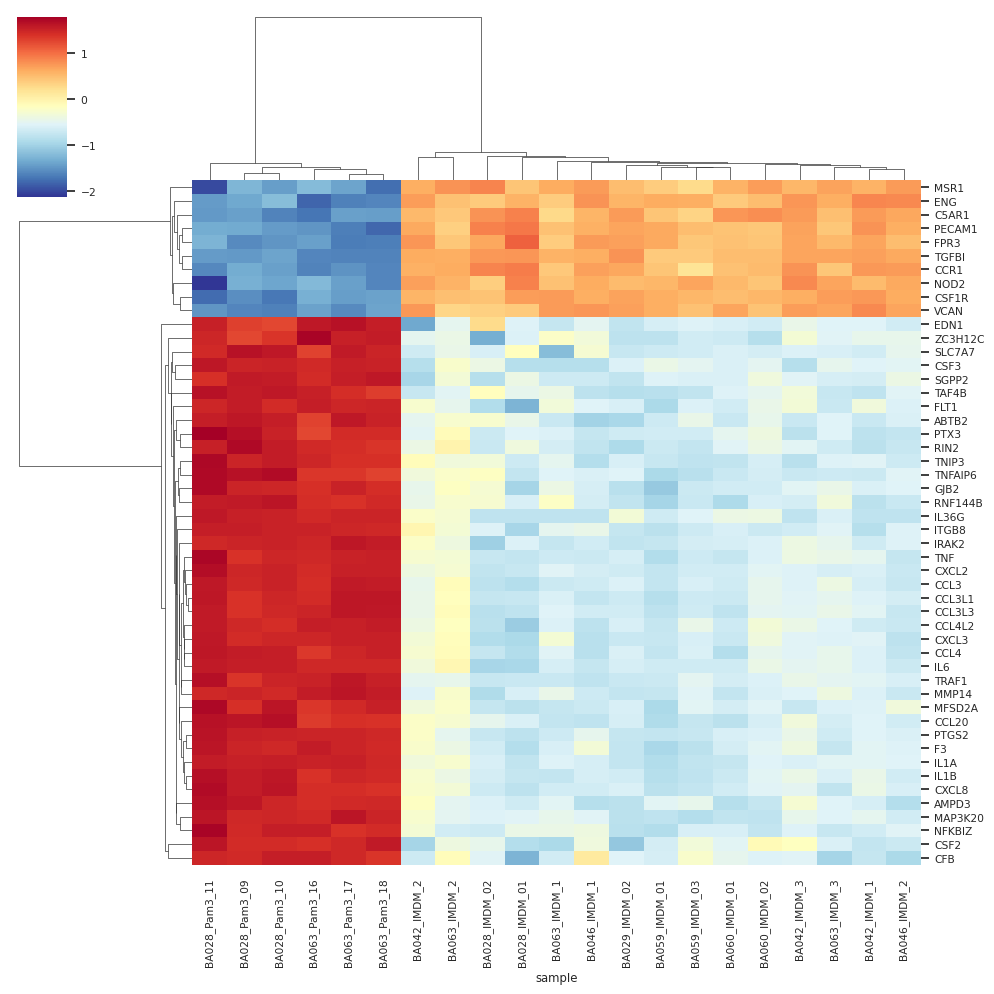

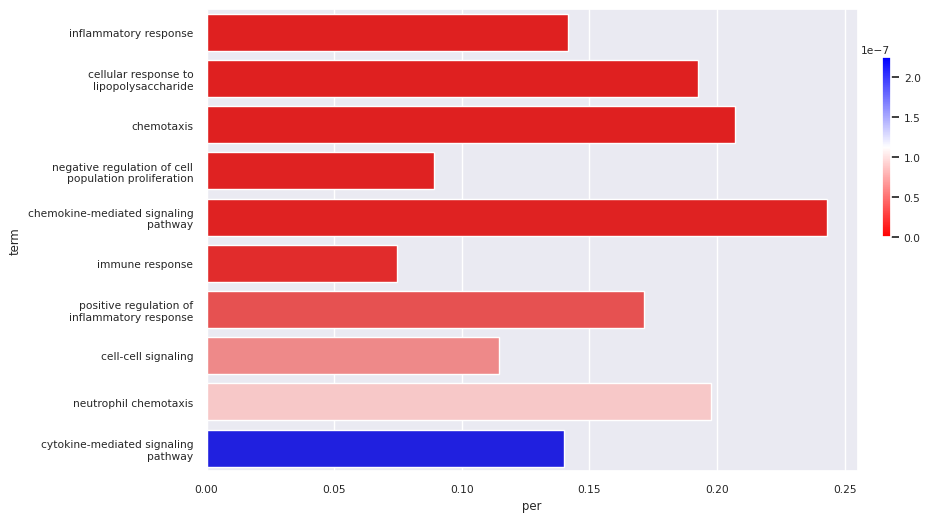

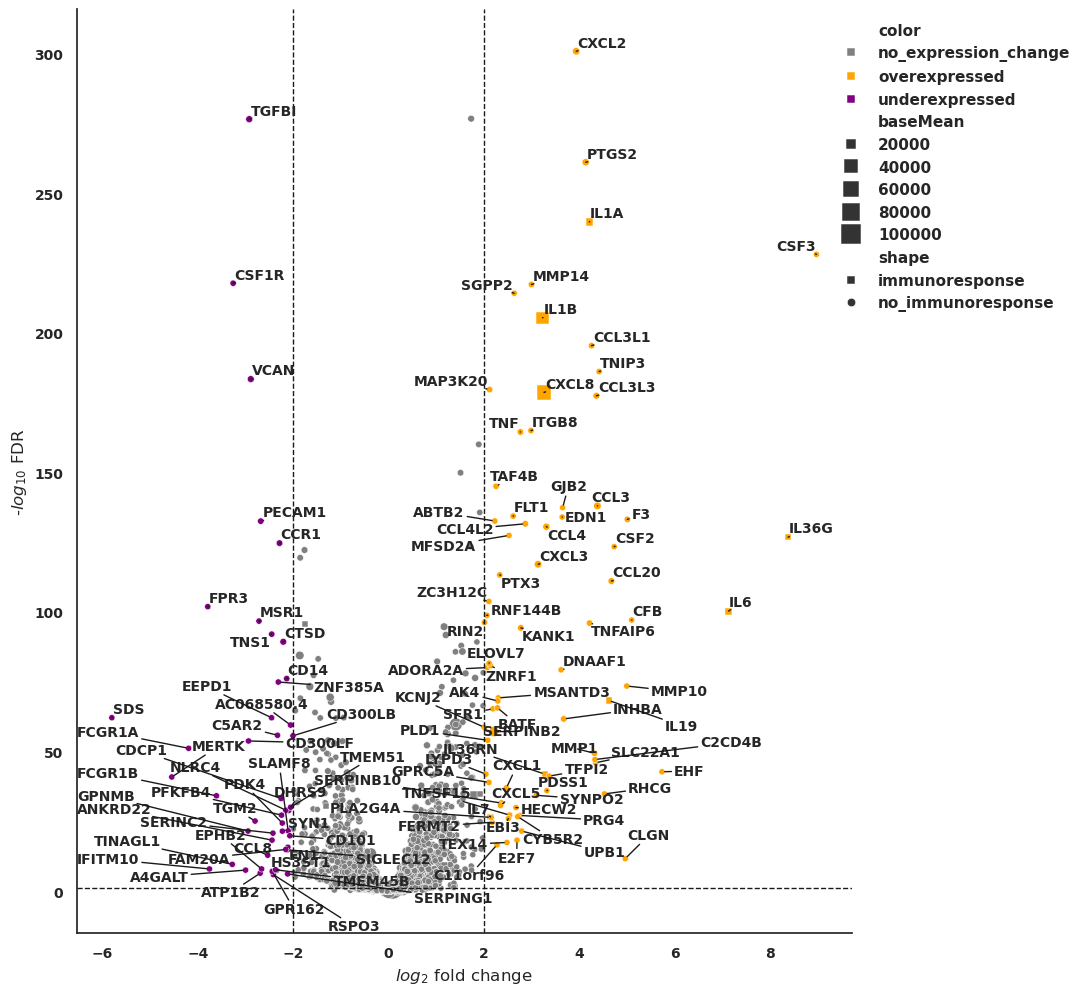

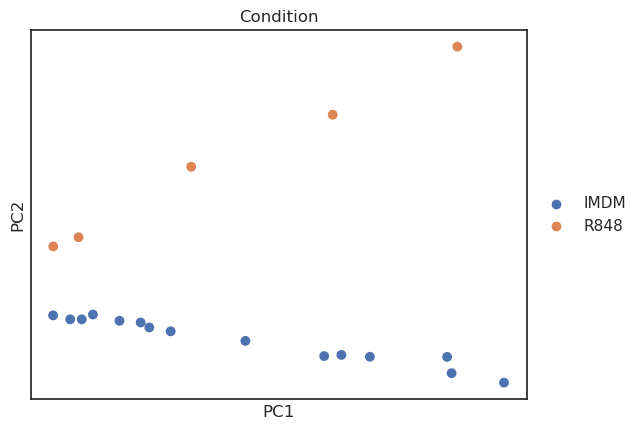

Running Wald tests...
... done in 1.14 seconds.

/tmp/ipykernel_3556066/1625812066.py:6: ImplicitModificationWarning: Setting element `.layers['log1p']` of view, initializing view as actual.
  dds_sigs.layers["log1p"] = np.log1p(dds_sigs.layers["normed_counts"])


Log2 fold change & Wald test p-value: Condition R848 vs IMDM
           baseMean  log2FoldChange     lfcSE       stat        pvalue  \
KLHL8    122.248297        0.544147  0.091751   5.930696  3.016532e-09   
ZNF576    52.623158       -0.192132  0.159033  -1.208126  2.269988e-01   
FCF1     286.630968        0.210316  0.117358   1.792089  7.311877e-02   
TAF12     90.272432       -0.099718  0.141153  -0.706450  4.799082e-01   
GLRX      93.517505        0.942956  0.136952   6.885302  5.766524e-12   
...             ...             ...       ...        ...           ...   
TSN      400.697386       -0.092164  0.076413  -1.206128  2.277682e-01   
NFATC1   439.678088       -0.306628  0.073744  -4.158029  3.210054e-05   
PORCN     30.498700       -0.465044  0.187856  -2.475540  1.330349e-02   
REL     3393.881826        1.146833  0.091697  12.506803  6.852685e-36   
RPL23   3508.069483        0.227989  0.146498   1.556261  1.196461e-01   

                padj  
KLHL8   1.472033e-08  
ZNF5

/tmp/ipykernel_3556066/202939109.py:116: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([textwrap.fill(e, 30) for e in df["term"]])
/home/t.afanasyeva/mambaforge/envs/pydeseq2/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
/home/t.afanasyeva/mambaforge/envs/pydeseq2/lib/python3.11/site-packages/matplotlib/transforms.py:360: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 1] - points[0, 1]
posx and posy should be finite values
posx and posy should be finite values
posx and posy s

... done in 1.43 seconds.

Refitting 0 outliers.

/home/t.afanasyeva/mambaforge/envs/pydeseq2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 1200x1200 with 0 Axes>

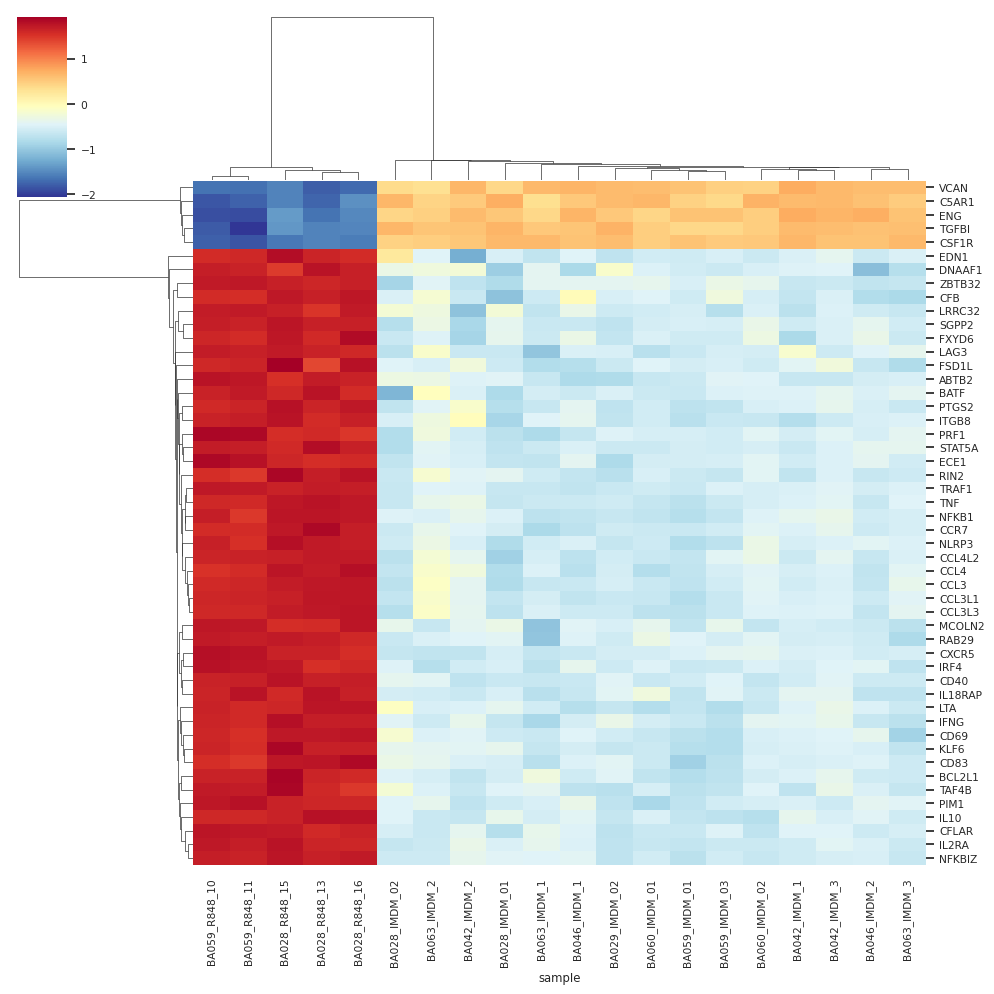

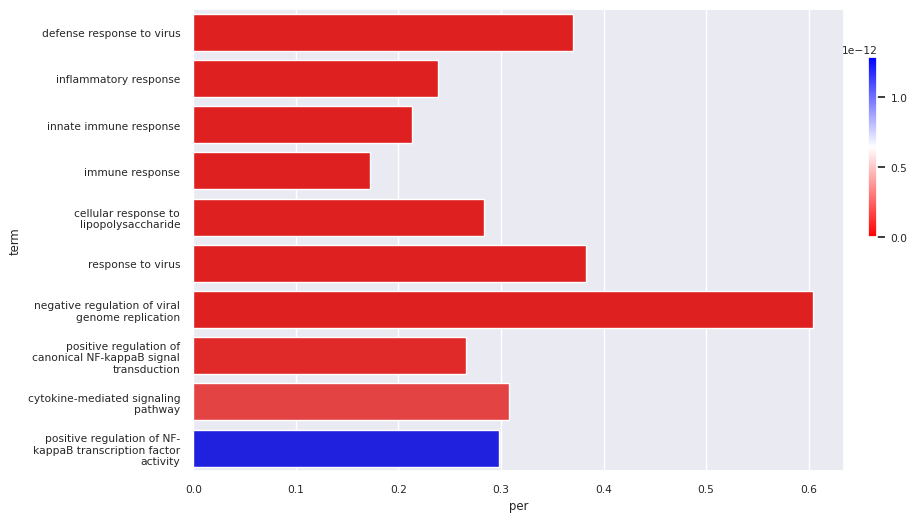

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


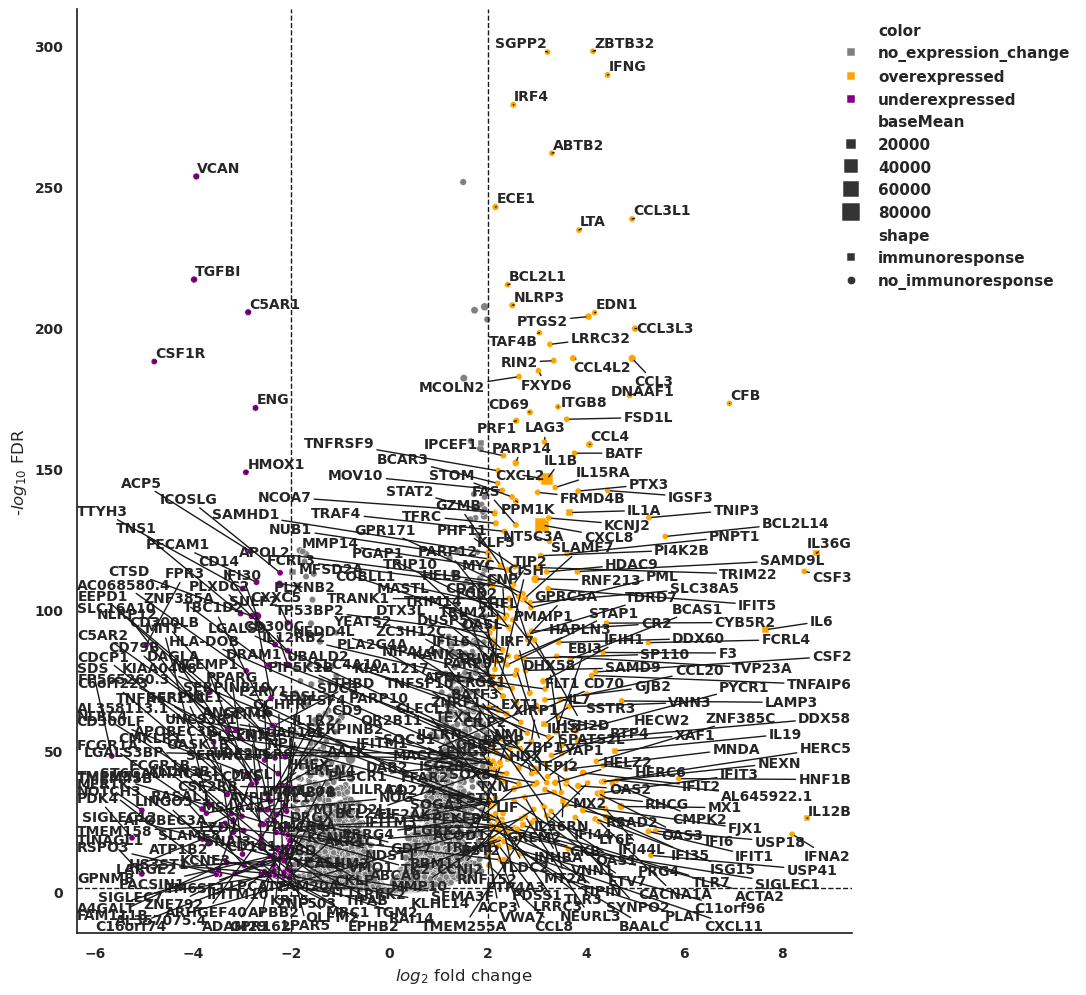

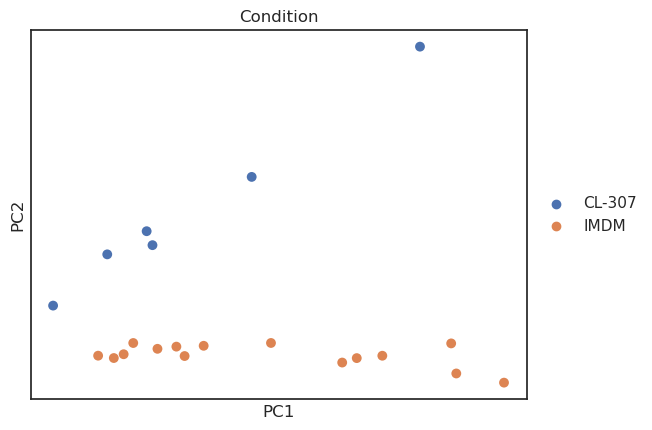

Running Wald tests...
... done in 1.15 seconds.

/tmp/ipykernel_3556066/1625812066.py:6: ImplicitModificationWarning: Setting element `.layers['log1p']` of view, initializing view as actual.
  dds_sigs.layers["log1p"] = np.log1p(dds_sigs.layers["normed_counts"])


Log2 fold change & Wald test p-value: Condition CL-307 vs IMDM
           baseMean  log2FoldChange     lfcSE       stat        pvalue  \
KLHL8    115.525629        0.457731  0.097283   4.705141  2.536906e-06   
ZNF576    46.821029       -0.457142  0.161010  -2.839226  4.522307e-03   
FCF1     263.274557        0.067109  0.104085   0.644754  5.190866e-01   
TAF12     83.241342       -0.256876  0.128398  -2.000626  4.543267e-02   
GLRX      84.483026        0.645855  0.142014   4.547840  5.419943e-06   
...             ...             ...       ...        ...           ...   
TSN      384.010554        0.043039  0.071963   0.598071  5.497927e-01   
NFATC1   430.999498       -0.036609  0.078388  -0.467026  6.404815e-01   
PORCN     31.439182        0.162512  0.178438   0.910743  3.624307e-01   
REL     3138.929733        0.981127  0.086598  11.329625  9.360416e-30   
RPL23   3076.981179       -0.159558  0.131849  -1.210162  2.262167e-01   

                padj  
KLHL8   1.523294e-05  
ZN

/tmp/ipykernel_3556066/202939109.py:116: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([textwrap.fill(e, 30) for e in df["term"]])
/home/t.afanasyeva/mambaforge/envs/pydeseq2/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
posx and posy should be finite values
/home/t.afanasyeva/mambaforge/envs/pydeseq2/lib/python3.11/site-packages/matplotlib/transforms.py:360: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 1] - points[0, 1]
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.55 seconds.

Fitting dispersion trend curve...
... done in 0.29 seconds.

Fitting MAP dispersions...
... done in 1.17

... done in 1.13 seconds.

Refitting 1 outliers.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

/home/t.afanasyeva/mambaforge/envs/pydeseq2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 1200x1200 with 0 Axes>

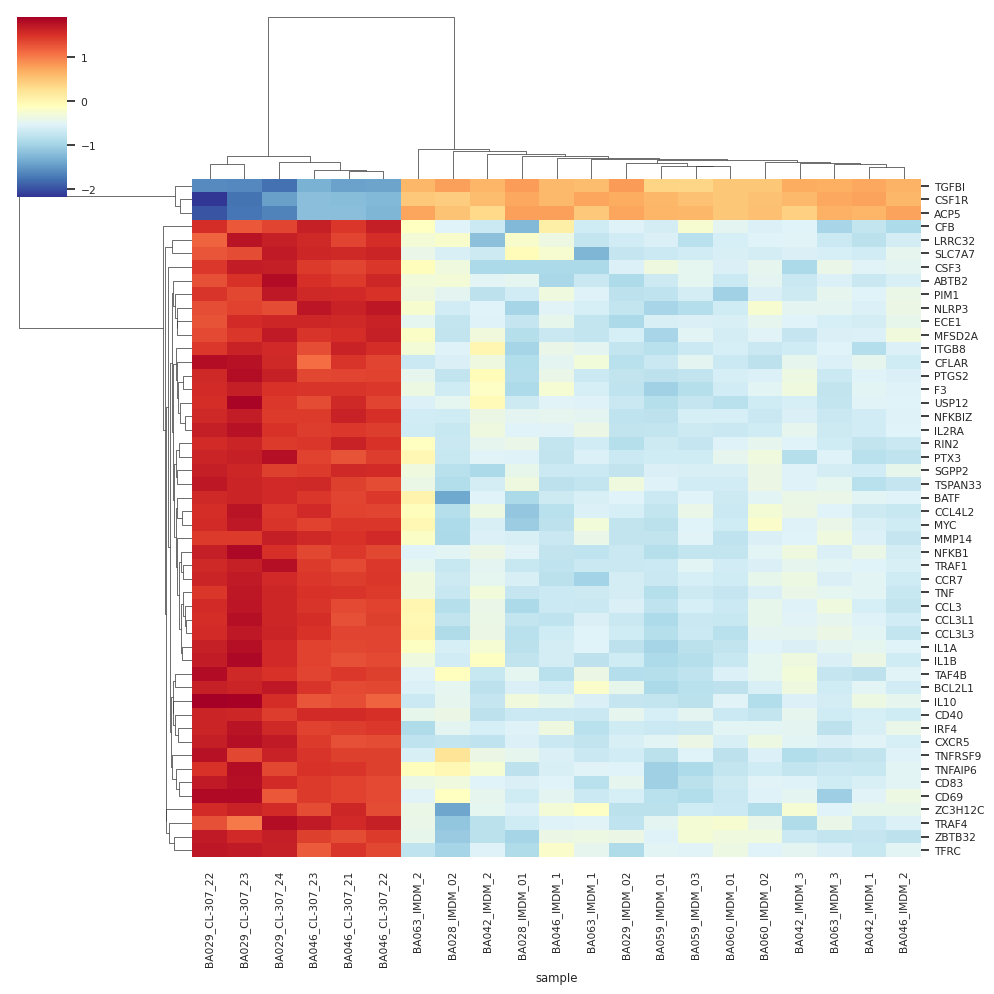

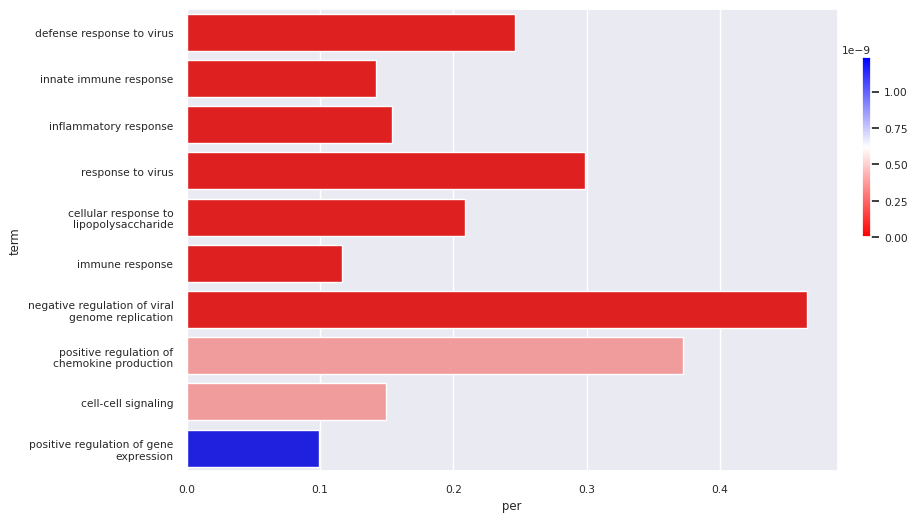

posx and posy should be finite values
posx and posy should be finite values


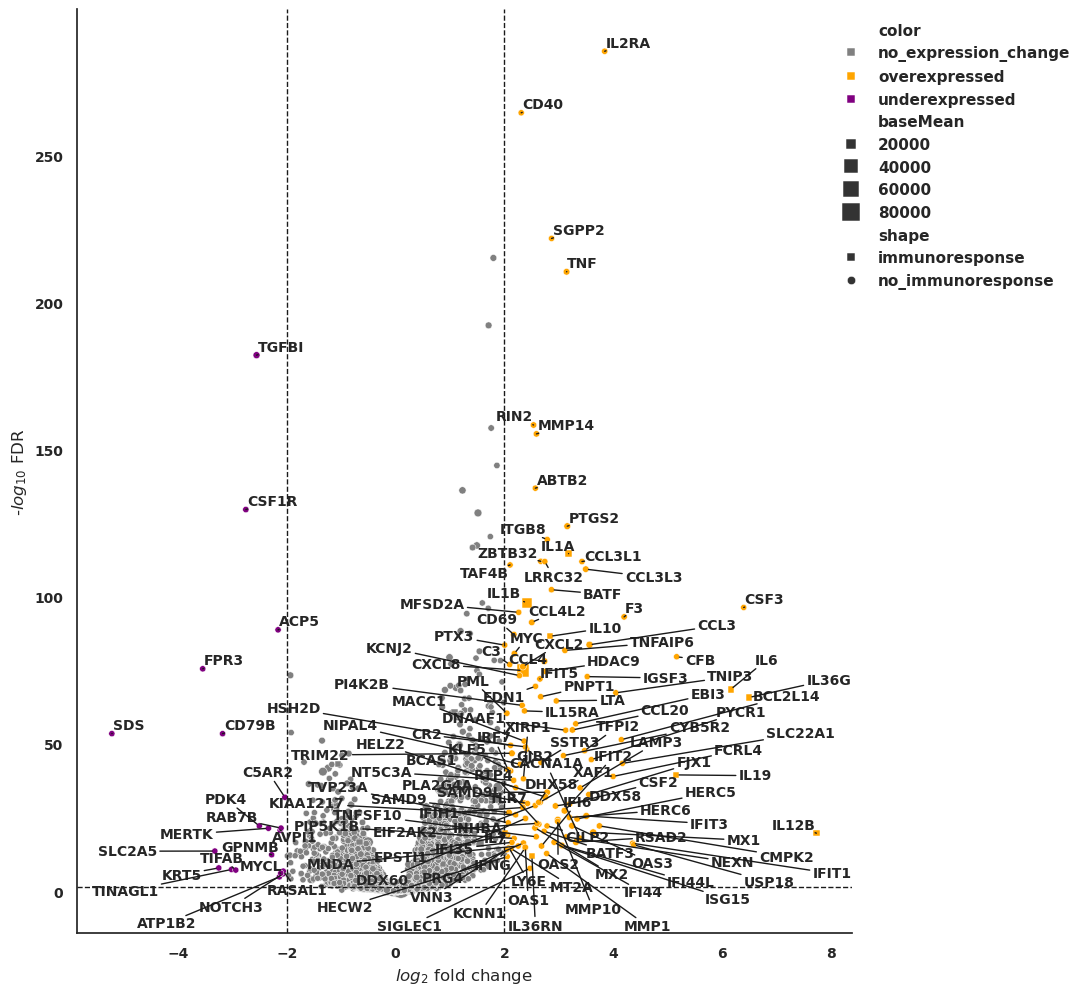

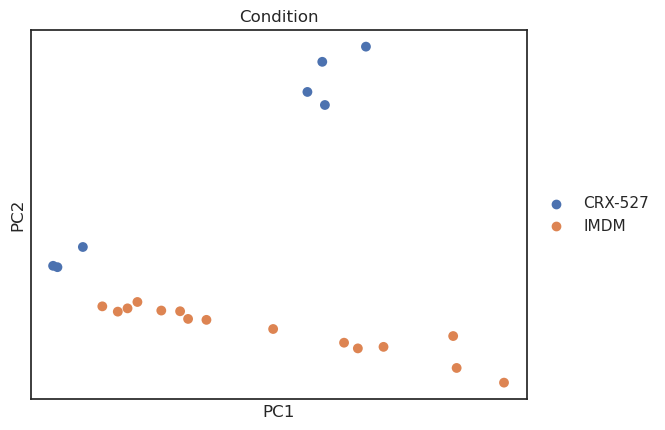

Running Wald tests...
... done in 1.10 seconds.

/tmp/ipykernel_3556066/1625812066.py:6: ImplicitModificationWarning: Setting element `.layers['log1p']` of view, initializing view as actual.
  dds_sigs.layers["log1p"] = np.log1p(dds_sigs.layers["normed_counts"])


Log2 fold change & Wald test p-value: Condition CRX-527 vs IMDM
           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
KLHL8    118.950695        0.580233  0.098967  5.862908  4.548304e-09   
ZNF576    45.153296       -0.258475  0.159989 -1.615581  1.061850e-01   
FCF1     258.893109        0.091270  0.103072  0.885490  3.758923e-01   
TAF12     77.323636       -0.342185  0.122155 -2.801227  5.090872e-03   
GLRX      75.162550        0.315475  0.128217  2.460481  1.387507e-02   
...             ...             ...       ...       ...           ...   
TSN      372.317269       -0.000663  0.077328 -0.008568  9.931635e-01   
NFATC1   425.369437       -0.002491  0.077059 -0.032319  9.742173e-01   
PORCN     30.917492        0.081015  0.169747  0.477270  6.331695e-01   
REL     2480.058115        0.160370  0.092447  1.734721  8.279024e-02   
RPL23   3118.244747        0.048471  0.129144  0.375322  7.074208e-01   

                padj  
KLHL8   4.708344e-08  
ZNF576  2.140

/tmp/ipykernel_3556066/202939109.py:116: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([textwrap.fill(e, 30) for e in df["term"]])
/home/t.afanasyeva/mambaforge/envs/pydeseq2/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
posx and posy should be finite values
/home/t.afanasyeva/mambaforge/envs/pydeseq2/lib/python3.11/site-packages/matplotlib/transforms.py:360: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 1] - points[0, 1]
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.18 seconds.

Fitting dispersion trend curve...
... done in 0.32 seconds.

Fitting MAP dispersions...
... done in 1.53

... done in 1.16 seconds.

Refitting 4 outliers.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

/home/t.afanasyeva/mambaforge/envs/pydeseq2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 1200x1200 with 0 Axes>

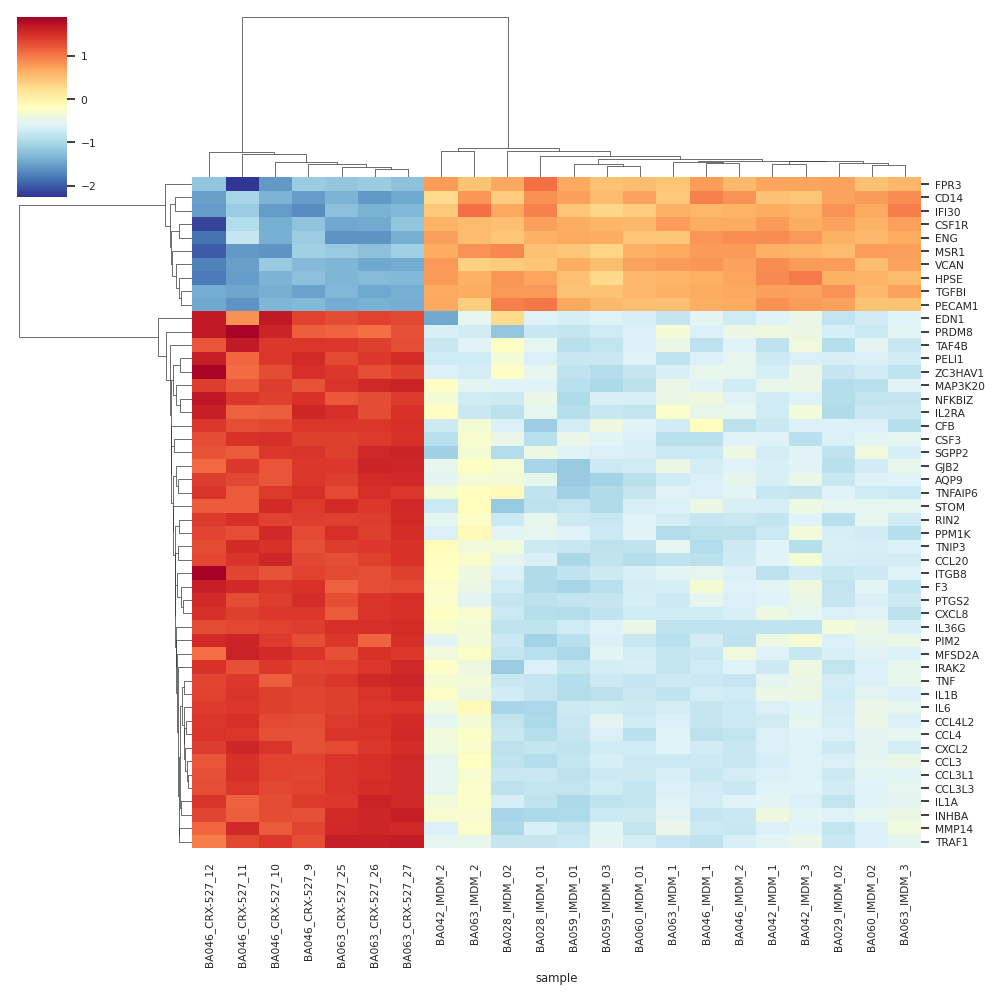

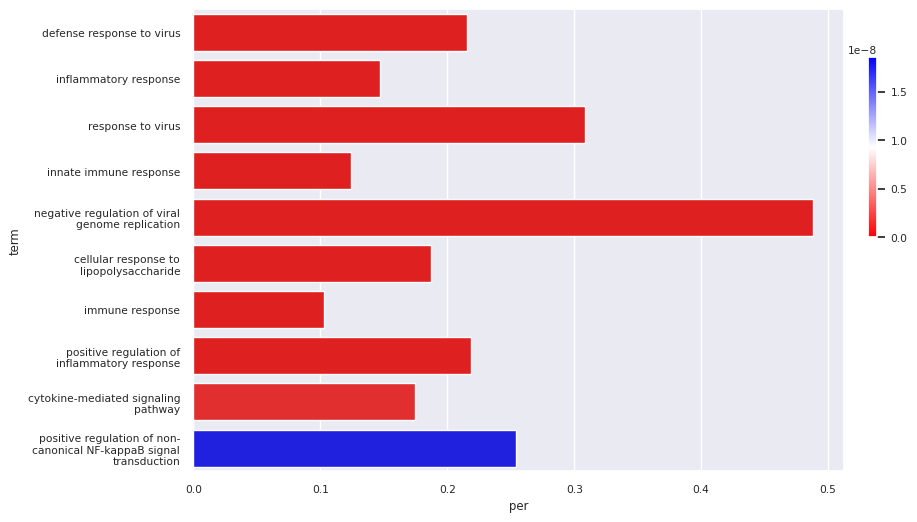

posx and posy should be finite values
posx and posy should be finite values


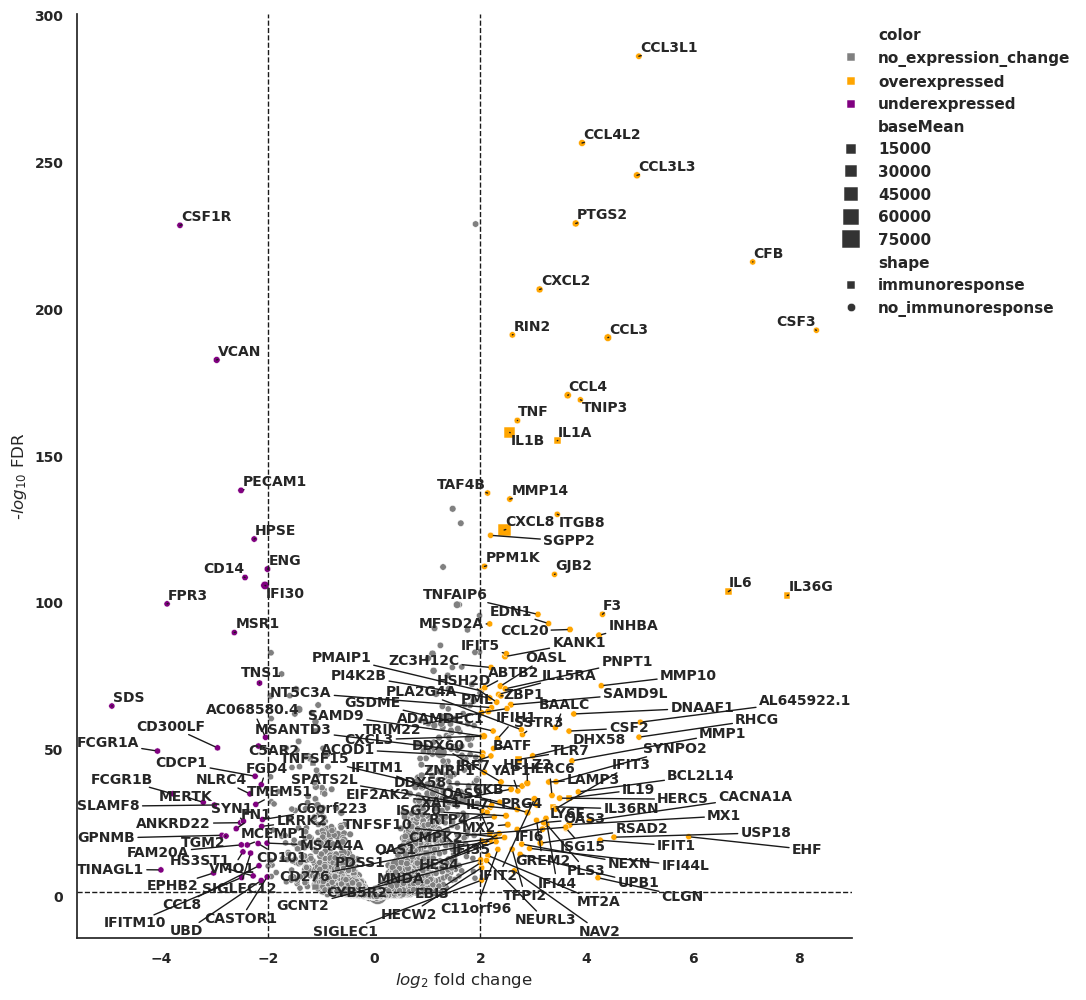

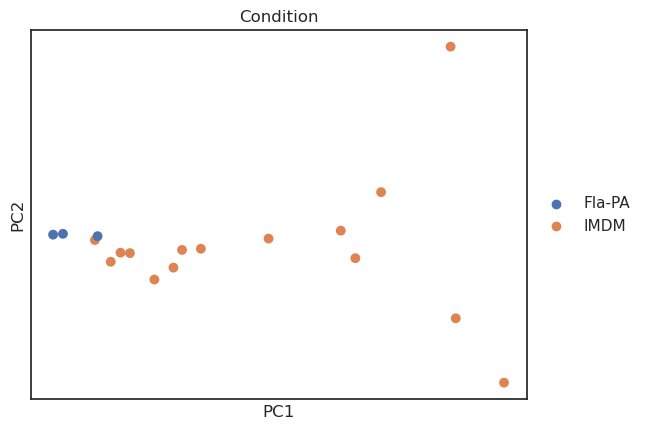

Running Wald tests...
... done in 1.23 seconds.

/tmp/ipykernel_3556066/1625812066.py:6: ImplicitModificationWarning: Setting element `.layers['log1p']` of view, initializing view as actual.
  dds_sigs.layers["log1p"] = np.log1p(dds_sigs.layers["normed_counts"])


Log2 fold change & Wald test p-value: Condition Fla-PA vs IMDM
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
KLHL8     97.055382        0.120136  0.168031  0.714967  0.474630  0.712619
ZNF576    48.676718        0.182911  0.231337  0.790669  0.429137  0.673920
FCF1     246.692599        0.107302  0.156285  0.686580  0.492347  0.726459
TAF12     82.855694        0.181680  0.202845  0.895662  0.370434  0.626004
GLRX      72.179886        0.540178  0.211334  2.556045  0.010587  0.067617
...             ...             ...       ...       ...       ...       ...
TSN      365.966705        0.137098  0.109203  1.255441  0.209319  0.452927
NFATC1   425.345872        0.291692  0.119883  2.433148  0.014968  0.086352
PORCN     26.213531       -1.122162  0.408446 -2.747396  0.006007  0.045322
REL     2416.916784        0.371778  0.114530  3.246123  0.001170  0.012988
RPL23   2964.133367       -0.033173  0.177145 -0.187265  0.851453  0.937538

[11856 rows x 6 columns]

/tmp/ipykernel_3556066/202939109.py:116: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([textwrap.fill(e, 30) for e in df["term"]])


<Figure size 1200x1200 with 0 Axes>

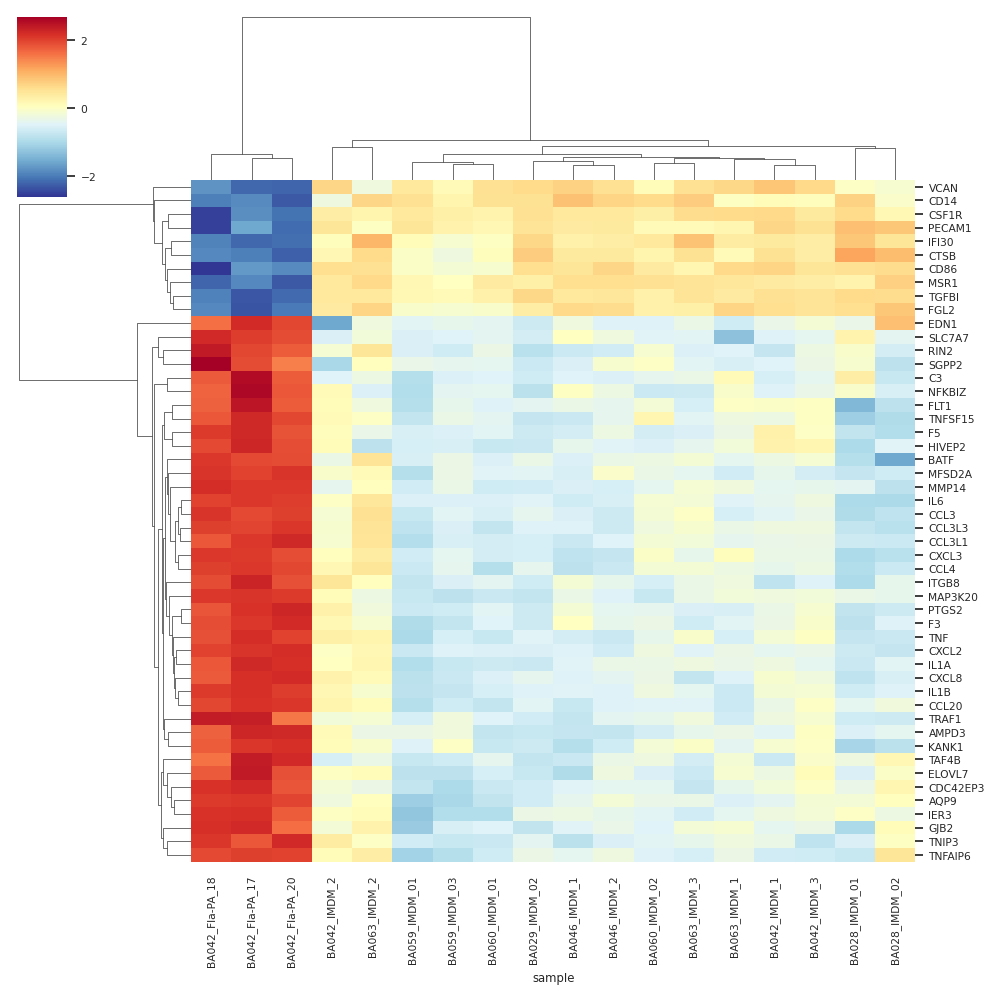

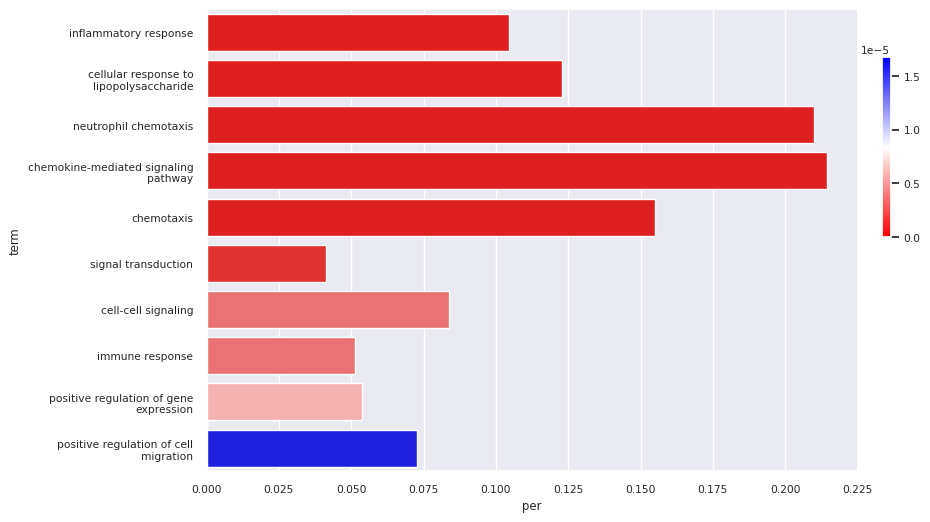

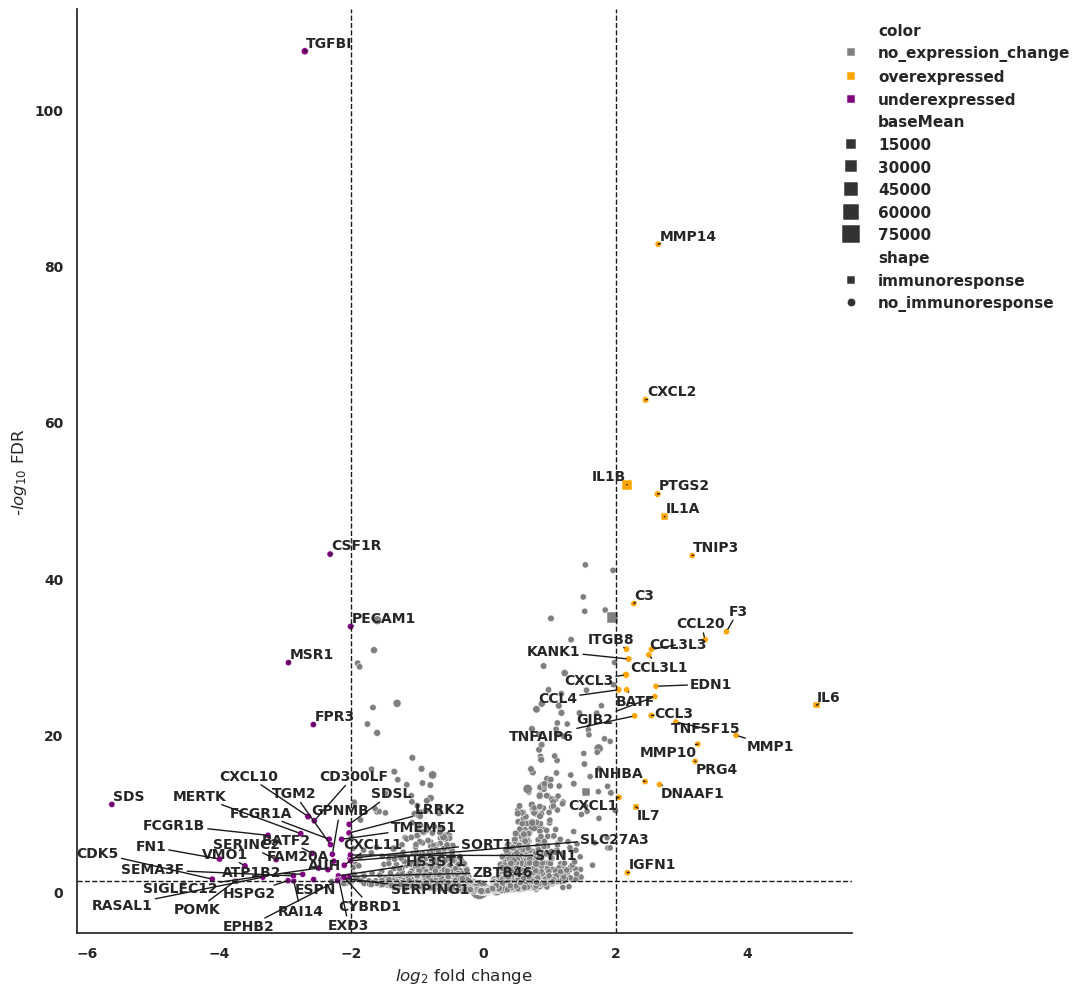

In [12]:
for class_pair in list_of_classes_to_include:
    analysis_name = f"{class_pair[0]}_vs_{class_pair[1]}"

    results_directory = os.path.join(current_directory, analysis_name)
    if not os.path.exists(results_directory):
        os.makedirs(results_directory)

    counts, metadata = prepare_counts_metadata(raw_counts, class_pair)
    dds, res, sigs = deseq(analysis_name, counts, metadata, class_pair)

    _ = make_historgram_for_sign_genes(dds, sigs, num_top_sign=50)

    go_df = go_it(sigs.index, mapper, goeaobj, go_items)
    _ = make_go_plot(go_df[0:10], results_directory, analysis_name)

    _ = make_volcano_plot(res, immunoresponse_genes, results_directory, analysis_name)